## FDW Crop Production Data Profiling - Zambia

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32735' 
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/ZM_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
#read in username and password

auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Zambia',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1980	 | ZM1980A1 | 9	| ZM1980A2	| 57	| nan	| 0	|
| 1990	 | ZM1990A1 | 9	| nan	| 0	| nan	| 0	|
| 1998	 | nan | 0	| ZM1998A2	| 72	| nan	| 0	|
| 2011	 | ZM2011A1 | 10	| ZM2011A2	| 74	| nan	| 0	|
| 2012	 | ZM2012A1 | 10	| ZM2012A2	| 89	| nan	| 0	|
| 2016	 | ZM2016A1 | 10	| ZM2016A2	| 106	| nan	| 0	|
| 2017	 | ZM2017A1 | 10	| ZM2017A2	| 109	| nan	| 0	|
| 2018	 | ZM2018A1 | 10	| ZM2018A2	| 116	| nan	| 0	|
| 2021	 | ZM2021A1 | 10	| ZM2021A2	| 116	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #

#1)Zambia admin 2 uses a 1998 FNID while all others use 1980 FNID in some early 90s pre-1998 years (district exists both pre- and post- 1998)
df['fnid'][(df.fnid=='ZM1998A21212')&(df.season_date.str[:4].astype(int)<1998)] ='ZM1980A21208'#fix ZM FNID in the pre-1998 years

#2) Zambia has three different names for maize, two refer to the same crop and the third is marginal and should be removed
df = df[~(df['product']=='Maize Grain (Yellow)')] #drop the Maize Grain (Yellow) obs, which are only present in 1-2 admins for 2 years
df.loc[(df['product']=='Maize Grain (White)'),'product'] = 'Maize (Corn)' #rename complementary product names to be the same

# 3. Default setting 
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'

#4. Manual setting
# a) population groups within admin units
# Zambia has a number of admin 2 units with population groups that split the admin into two, 
# (e.g. ~Lusaka Rural East~ and ~Lusaka Rural West~). These two groups need to be recombined to map because
# there is no regional shapefile definition for these sub-admin units (for some countries there is)
#
# Calculate the sum of production, harvested area and planted area, then recalculate yield for these admin units
rows = ['fnid','season_year', 'product','indicator','crop_production_system','value','population_group']
#find duplicates then aggregate to fnid after pivoting around the indicator
dupes = df[rows[:-1]][df[rows[:-2]].duplicated(keep=False)]
#create a df that has one value per duplicated value
toFill = df[df[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep=False)]# find all duplicates
toFill = toFill[~toFill[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep='first')]# keep only one
dupes = dupes.groupby(by=['fnid','season_year','indicator','crop_production_system','product']).sum()
dupes.reset_index(inplace=True)
d_ha = dupes.copy(deep=True)
d_pa = dupes.copy(deep=True)
d_ha['value'].loc[dupes.indicator=='Yield'] = d_ha['value'].loc[d_ha.indicator=='Quantity Produced'].values/\
                                               d_ha['value'].loc[d_ha.indicator=='Area Harvested'].values
#if calculated yield is nan (meaning HA = 0), recalculate w/ planted area
d_pa['value'].loc[dupes.indicator=='Yield'] = d_pa['value'].loc[d_pa.indicator=='Quantity Produced'].values/\
                                               d_pa['value'].loc[d_pa.indicator=='Area Planted'].values
#For Zambia the planted area seems to be more reliable, so let's use planted area consistently rather than harvested area
dupes['value'].loc[dupes.indicator=='Yield'] = d_pa['value'].loc[dupes.indicator=='Yield']
#find where calculated yield is nan when calculated with PA and use HA instead
dupes['value'].loc[(dupes.indicator=='Yield')&(~np.isfinite(dupes.value))] = \
      d_ha['value'].loc[(dupes.indicator=='Yield')&(~np.isfinite(dupes.value))]
#set 0 back to nan
dupes['value'].loc[dupes.value==0]=np.nan
#merge the new values back into the placeholder DF
toFill = toFill.drop(['value'],axis=1)
toFill = toFill.merge(dupes, how='left',on = ['fnid','season_year','indicator','crop_production_system','product'])
#drop all duplicate obs from original DF and append the filled DF
df = df[~df[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep=False)]
df = df.append(toFill)
#becasue the population groups have been recombined, set them all equal to 'none'
df['population_group'] = 'none'

#5) limit to areas with collected data
df = df[df['status'] == 'Collected']

#6) Rename the unspecified variety of Millet to be the same crop as Millet (Finger) in 2011, 
#then drop the 2015 and 2016 obs b/c they're not the same crop
df = df[~((df['product']=='Millet (Finger)')&
              ((df.season_year=='Annual 2015')|(df.season_year=='Annual 2016')))]
df['product'][df['product']=='Millet (Finger)'] = 'Millet'

#7) remove a couple of incorrect values (off by multiple orders of magnitude) that couldn't be corrected
df['value'][(df['product']=='Sorghum')&(df.fnid=='ZM1998A20908')&(df.season_year=='Annual 2001')]=np.nan
df['value'][(df['product']=='Sorghum')&(df.fnid=='ZM1998A21207')&(df.season_year=='Annual 1998')]=np.nan

#8) fix one value, which is off by an order of magnitude according to the recorded yield value
df['value'][(df['indicator']=='Area Harvested')&(df['product']=='Rice (Paddy)')
   &(df.fnid=='ZM1998A20410')&(df.season_year=='Annual 2008')] = 40

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df,area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([ZM_Admin2_1980,ZM_Admin2_1998,ZM_Admin2_2011,ZM_Admin2_2012,ZM_Admin2_2016,ZM_Admin2_2017,ZM_Admin2_2018,ZM_Admin2_2021], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 89,260
13,918/13,918 "Area Harvested" points are retained.
25,534/25,534 "Area Planted" points are retained.
24,906/24,906 "Quantity Produced" points are retained.
24,902/24,902 "Yield" points are retained.
Current data points: 89,260

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1976 - 2023
37 grain types are found: Bambara groundnut, Barley (Unspecified), Barley planting seed, Beans (mixed), Cashew (unshelled), Cassava, Castor seed, Chili pepper (Unspecified), Coffee (unspecified), Cotton (Unspecified), Cowpea (unspecified), Fodder grass (unspecified), Groundnuts (In Shell), Maize (Corn), Maize Grain (Yellow, No. 2), Maize fodder, Maize/corn grain (popcorn), Maize/corn planting seed, Millet, Millet (Bulrush), Pineapple (unspecified), Potato (Irish), Rice (Paddy), Sorghum, Sorghum (planting seed), Sorghum fodder, Soybean (unspecified), Sugarcane 

../figures/ZM_admin_shapes.png is saved.


## Zambia
Zambia crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-zambia.png?itok=UxZI1czA)

![USDA](https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/safrica_za_calendar.png)

- comparison of boundaries
![image](../figures/ZM_admin_shapes.png)

- In Zambia, basd on the FEWS NET data, there were four times of changes in administrative units: 1980, 1998, 2011, and 2012.

| year	 | Admin1   | # units   | Admin2   | # units   |Admin3   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  | :---:  | :---:  |
| | 1980	 | ZM1980A1 | 9	| ZM1980A2	| 57	| nan	| 0	|
| 1990	 | ZM1990A1 | 9	| nan	| 0	| nan	| 0	|
| 1998	 | nan | 0	| ZM1998A2	| 72	| nan	| 0	|
| 2012	 | ZM2012A1 | 10	| ZM2012A2	| 89	| nan	| 0	|
| 2016	 | ZM2016A1 | 10	| ZM2016A2	| 106	| nan	| 0	|
| 2017	 | ZM2017A1 | 10	| ZM2017A2	| 109	| nan	| 0	|
| 2018	 | ZM2018A1 | 10	| ZM2018A2	| 116	| nan	| 0	|
| 2021	 | ZM2021A1 | 10	| ZM2021A2	| 116	| nan	| 0	|


- Here, we use **`ZM2021A2`** to represent all admin-level 2 crop data 
- The data is all reported as `Annual` for the season
- Original data have both 'none' and 'all' as production systems, but these are essentially the same, indicating a default produciton system so they have all been changed to 'none' types.

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = ZM_Admin2_2021.copy().to_crs('epsg:32735')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
#shape_used['ADMIN2'] = 'None'
#shape_all['ADMIN2'] = 'None'
#shape_latest['ADMIN2'] = 'None'
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
# - Aggregate grain data by grain type
#FlagGrainType = True
#[area, prod, area_all, prod_all] = FDW_PD_GrainTypeAgg([area, prod, area_all, prod_all], product_category)
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [5]:
# Link admin boundaries ------------------------- #
link_1998, over_1998 = FDW_PD_CreateAdminLink(ZM_Admin2_1998, ZM_Admin2_2021, 'ADMIN2', 'ADMIN2', prod, epsg)
link_1980, over_1980 = FDW_PD_CreateAdminLink(ZM_Admin2_1980, ZM_Admin2_2021, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2011, over_2011 = FDW_PD_CreateAdminLink(ZM_Admin2_2011, ZM_Admin2_2021, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2012, over_2012 = FDW_PD_CreateAdminLink(ZM_Admin2_2012, ZM_Admin2_2021, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2016, over_2016 = FDW_PD_CreateAdminLink(ZM_Admin2_2016, ZM_Admin2_2021, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2017, over_2017 = FDW_PD_CreateAdminLink(ZM_Admin2_2017, ZM_Admin2_2021, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2018, over_2018 = FDW_PD_CreateAdminLink(ZM_Admin2_2018, ZM_Admin2_2021, 'ADMIN2', 'ADMIN2', prod, epsg)
# Crop specific ratios
link_ratio_1998 = FDW_PD_RatioAdminLink(link_1998, prod, over_1998, mdx_pss)
link_ratio_1980 = FDW_PD_RatioAdminLink(link_1980, prod, over_1980, mdx_pss)
link_ratio_2011 = FDW_PD_RatioAdminLink(link_2011, prod, over_2011, mdx_pss)
link_ratio_2012 = FDW_PD_RatioAdminLink(link_2012, prod, over_2012, mdx_pss)
link_ratio_2016 = FDW_PD_RatioAdminLink(link_2016, prod, over_2016, mdx_pss)
link_ratio_2017 = FDW_PD_RatioAdminLink(link_2017, prod, over_2017, mdx_pss)
link_ratio_2018 = FDW_PD_RatioAdminLink(link_2018, prod, over_2018, mdx_pss)

# Merge link_ratio
assert link_ratio_1998.keys() == link_ratio_2018.keys()
assert link_ratio_1980.keys() == link_ratio_2018.keys()
assert link_ratio_2011.keys() == link_ratio_2018.keys()
assert link_ratio_2012.keys() == link_ratio_2018.keys()
assert link_ratio_2016.keys() == link_ratio_2018.keys()
assert link_ratio_2017.keys() == link_ratio_2018.keys()

link_merged = [link_ratio_1980, link_ratio_1998,link_ratio_2011,link_ratio_2012,link_ratio_2016,link_ratio_2017,link_ratio_2018]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
# stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_ZM.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_ZM_ratio.npz', link_ratio)


../data/crop/adm_crop_production_ZM.csv is saved.
../data/crop/adm_crop_production_ZM_ratio.npz is saved.


## Visualization of production data

E:\upload _gscd\gscd\notebook\tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


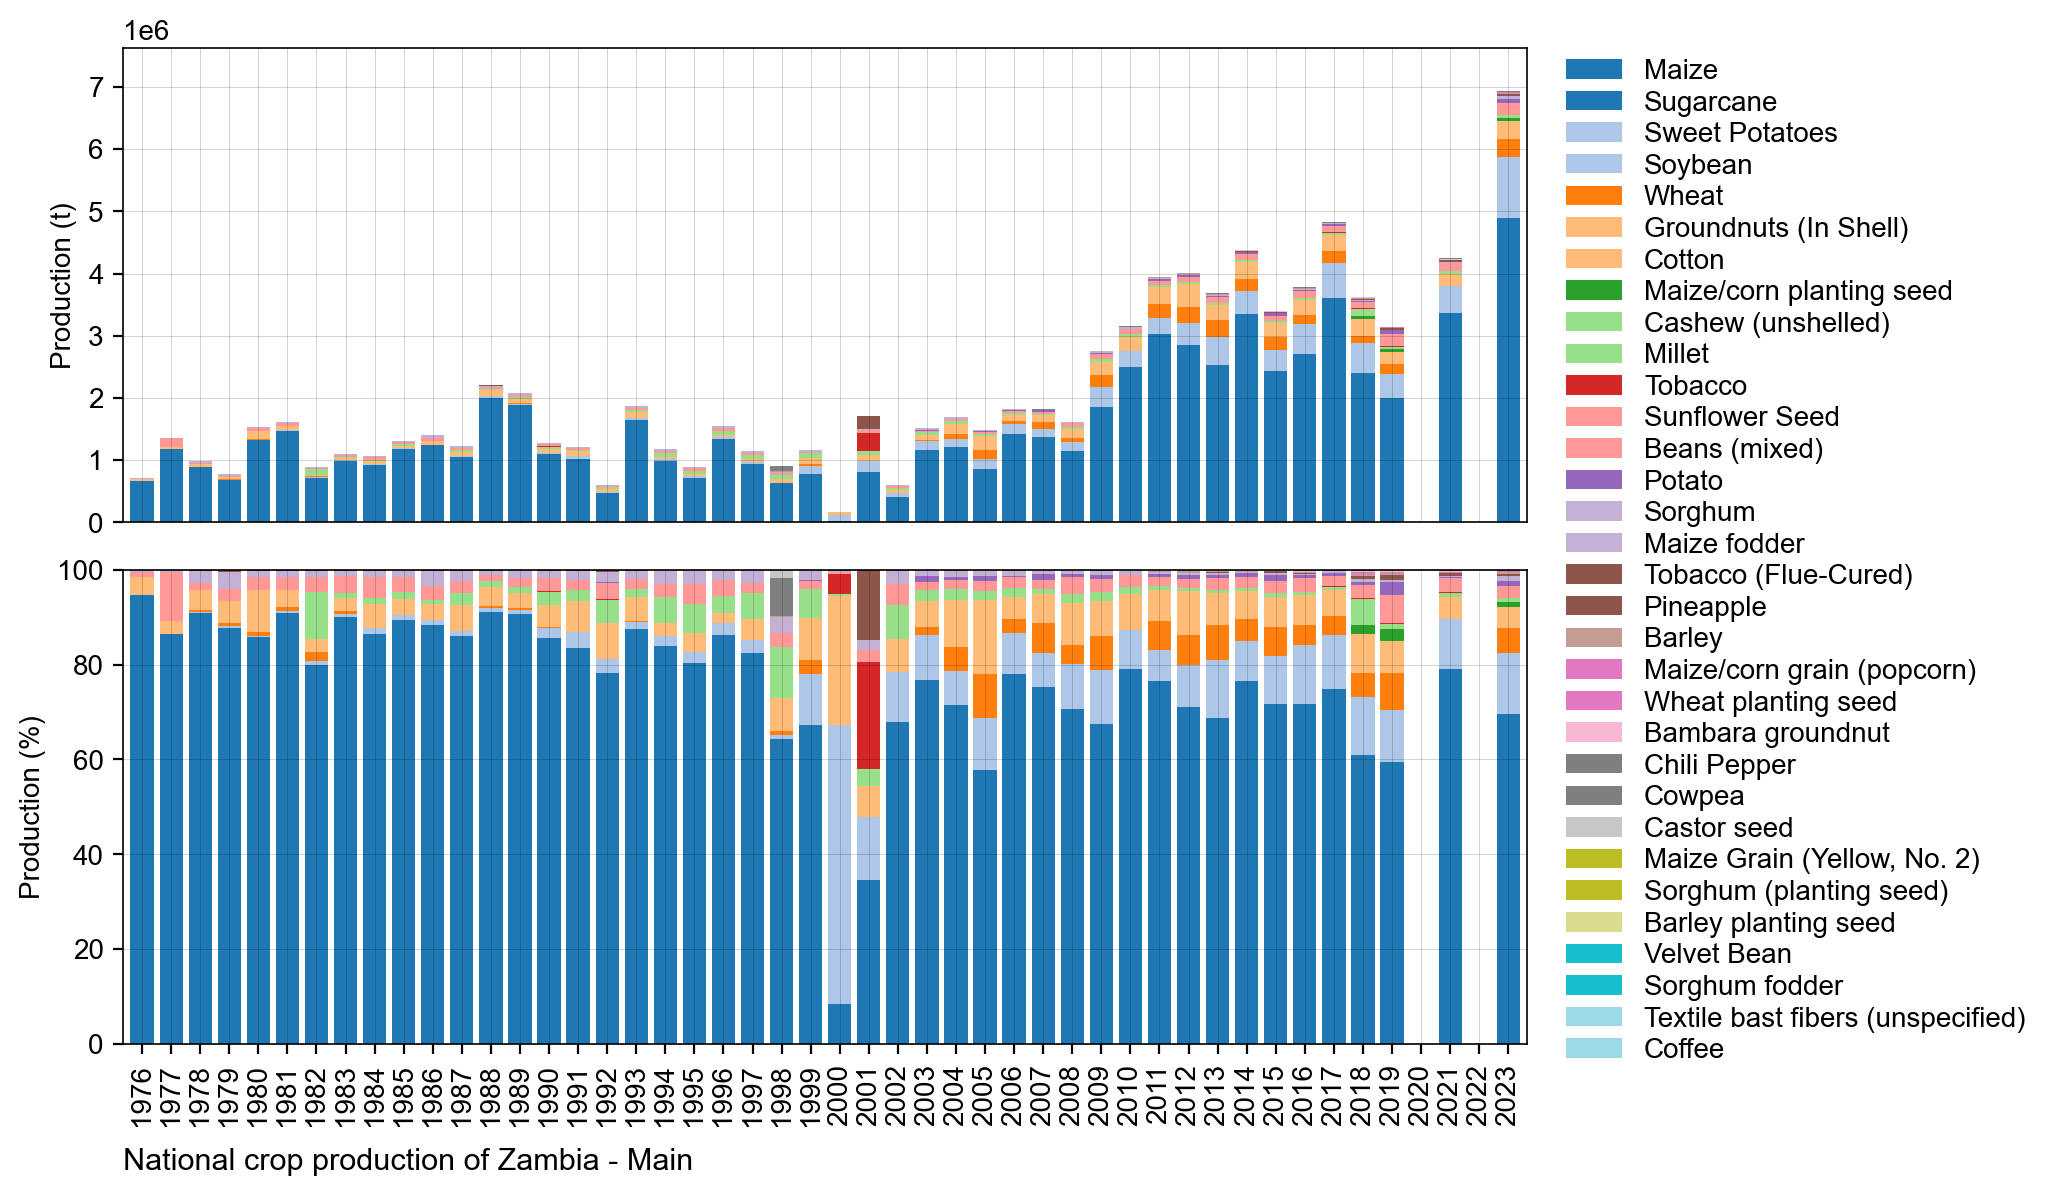

../figures/ZM_bar_natgrainprod_Main.png is saved.


E:\upload _gscd\gscd\notebook\tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


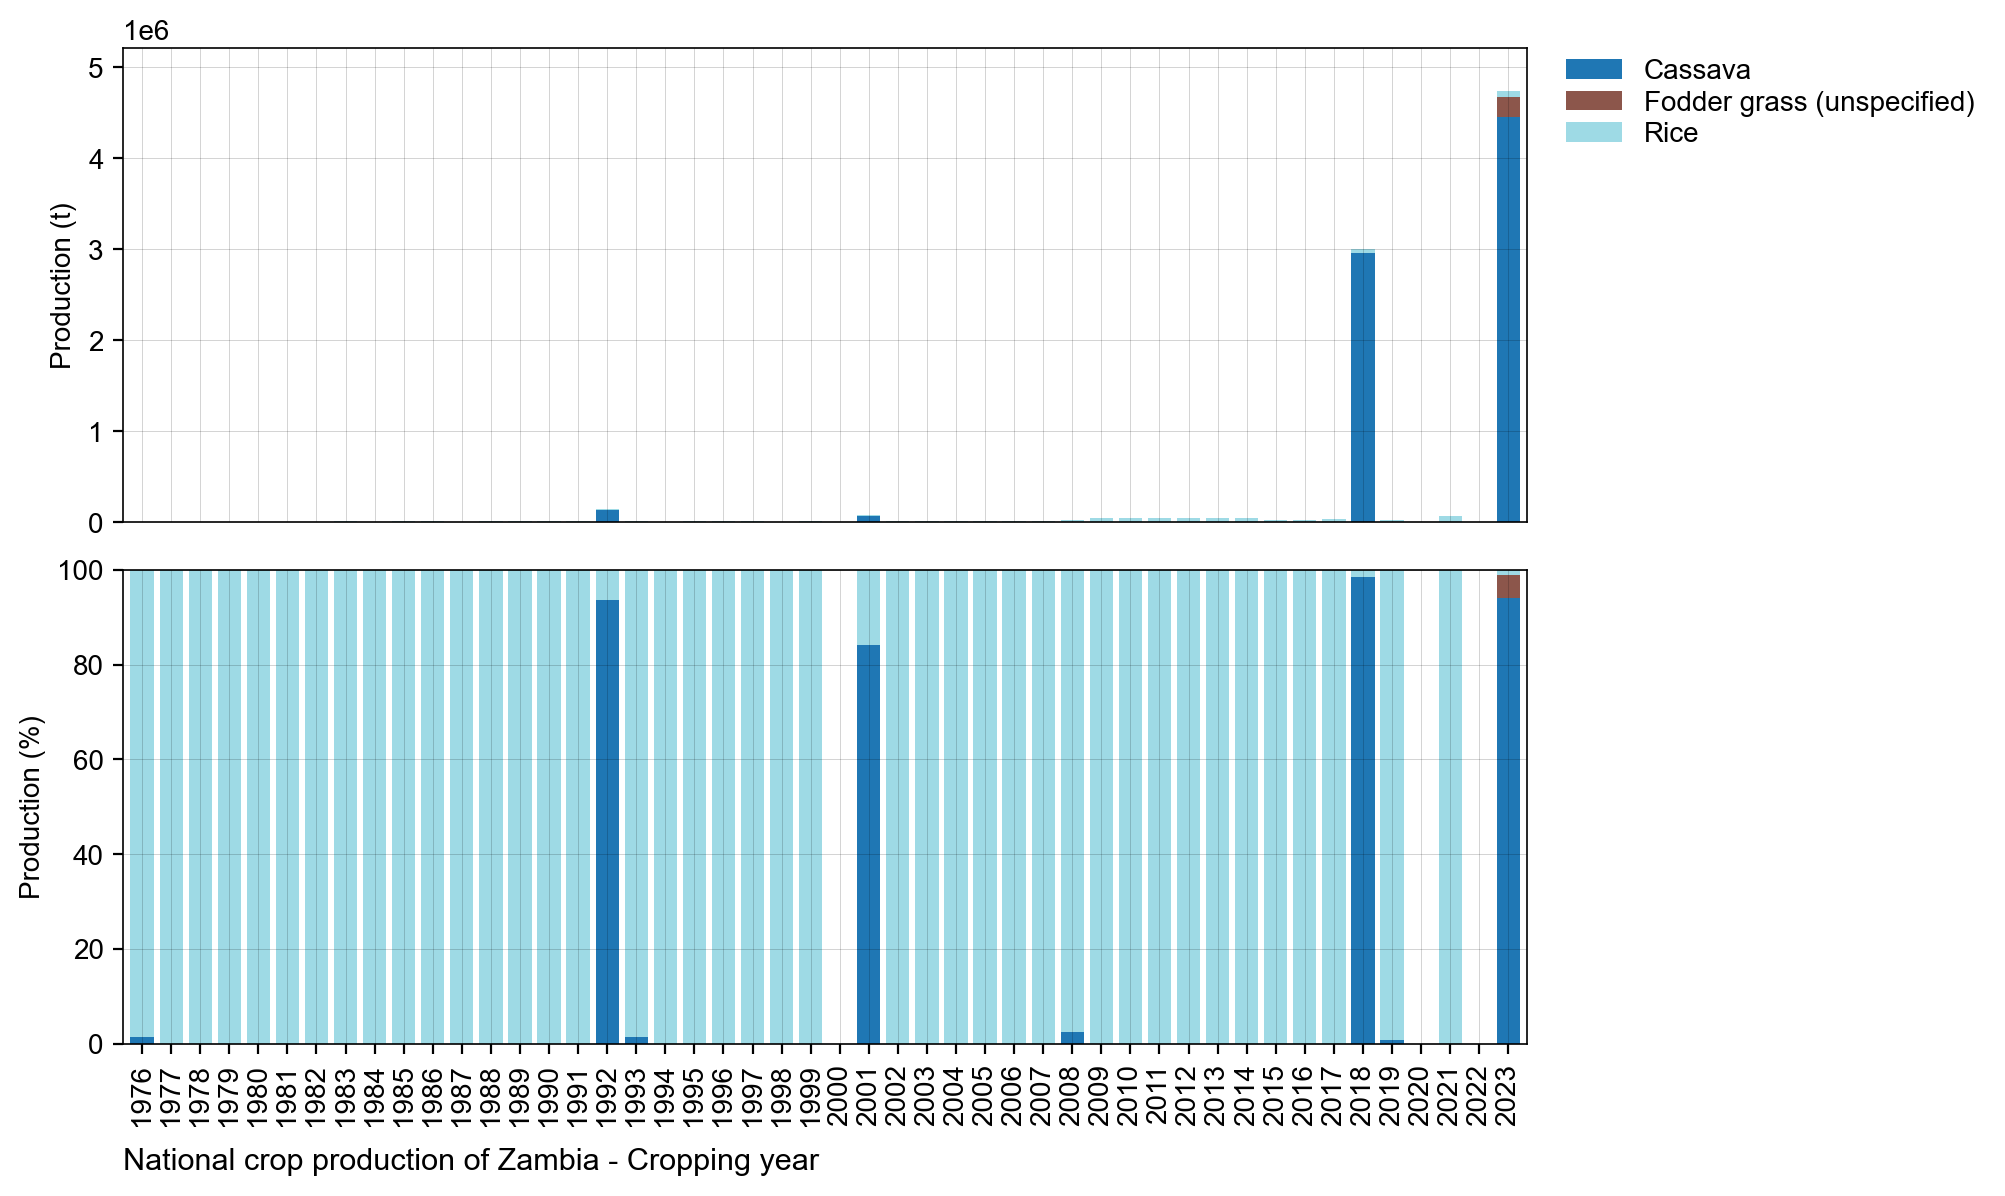

../figures/ZM_bar_natgrainprod_Cropping year.png is saved.


In [8]:
# Bar chart of national grain production
country_iso, country_name = 'ZM', 'Zambia'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main','Cropping year']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    
    
    PlotBarProduction(sub, year, footnote, fn_save)

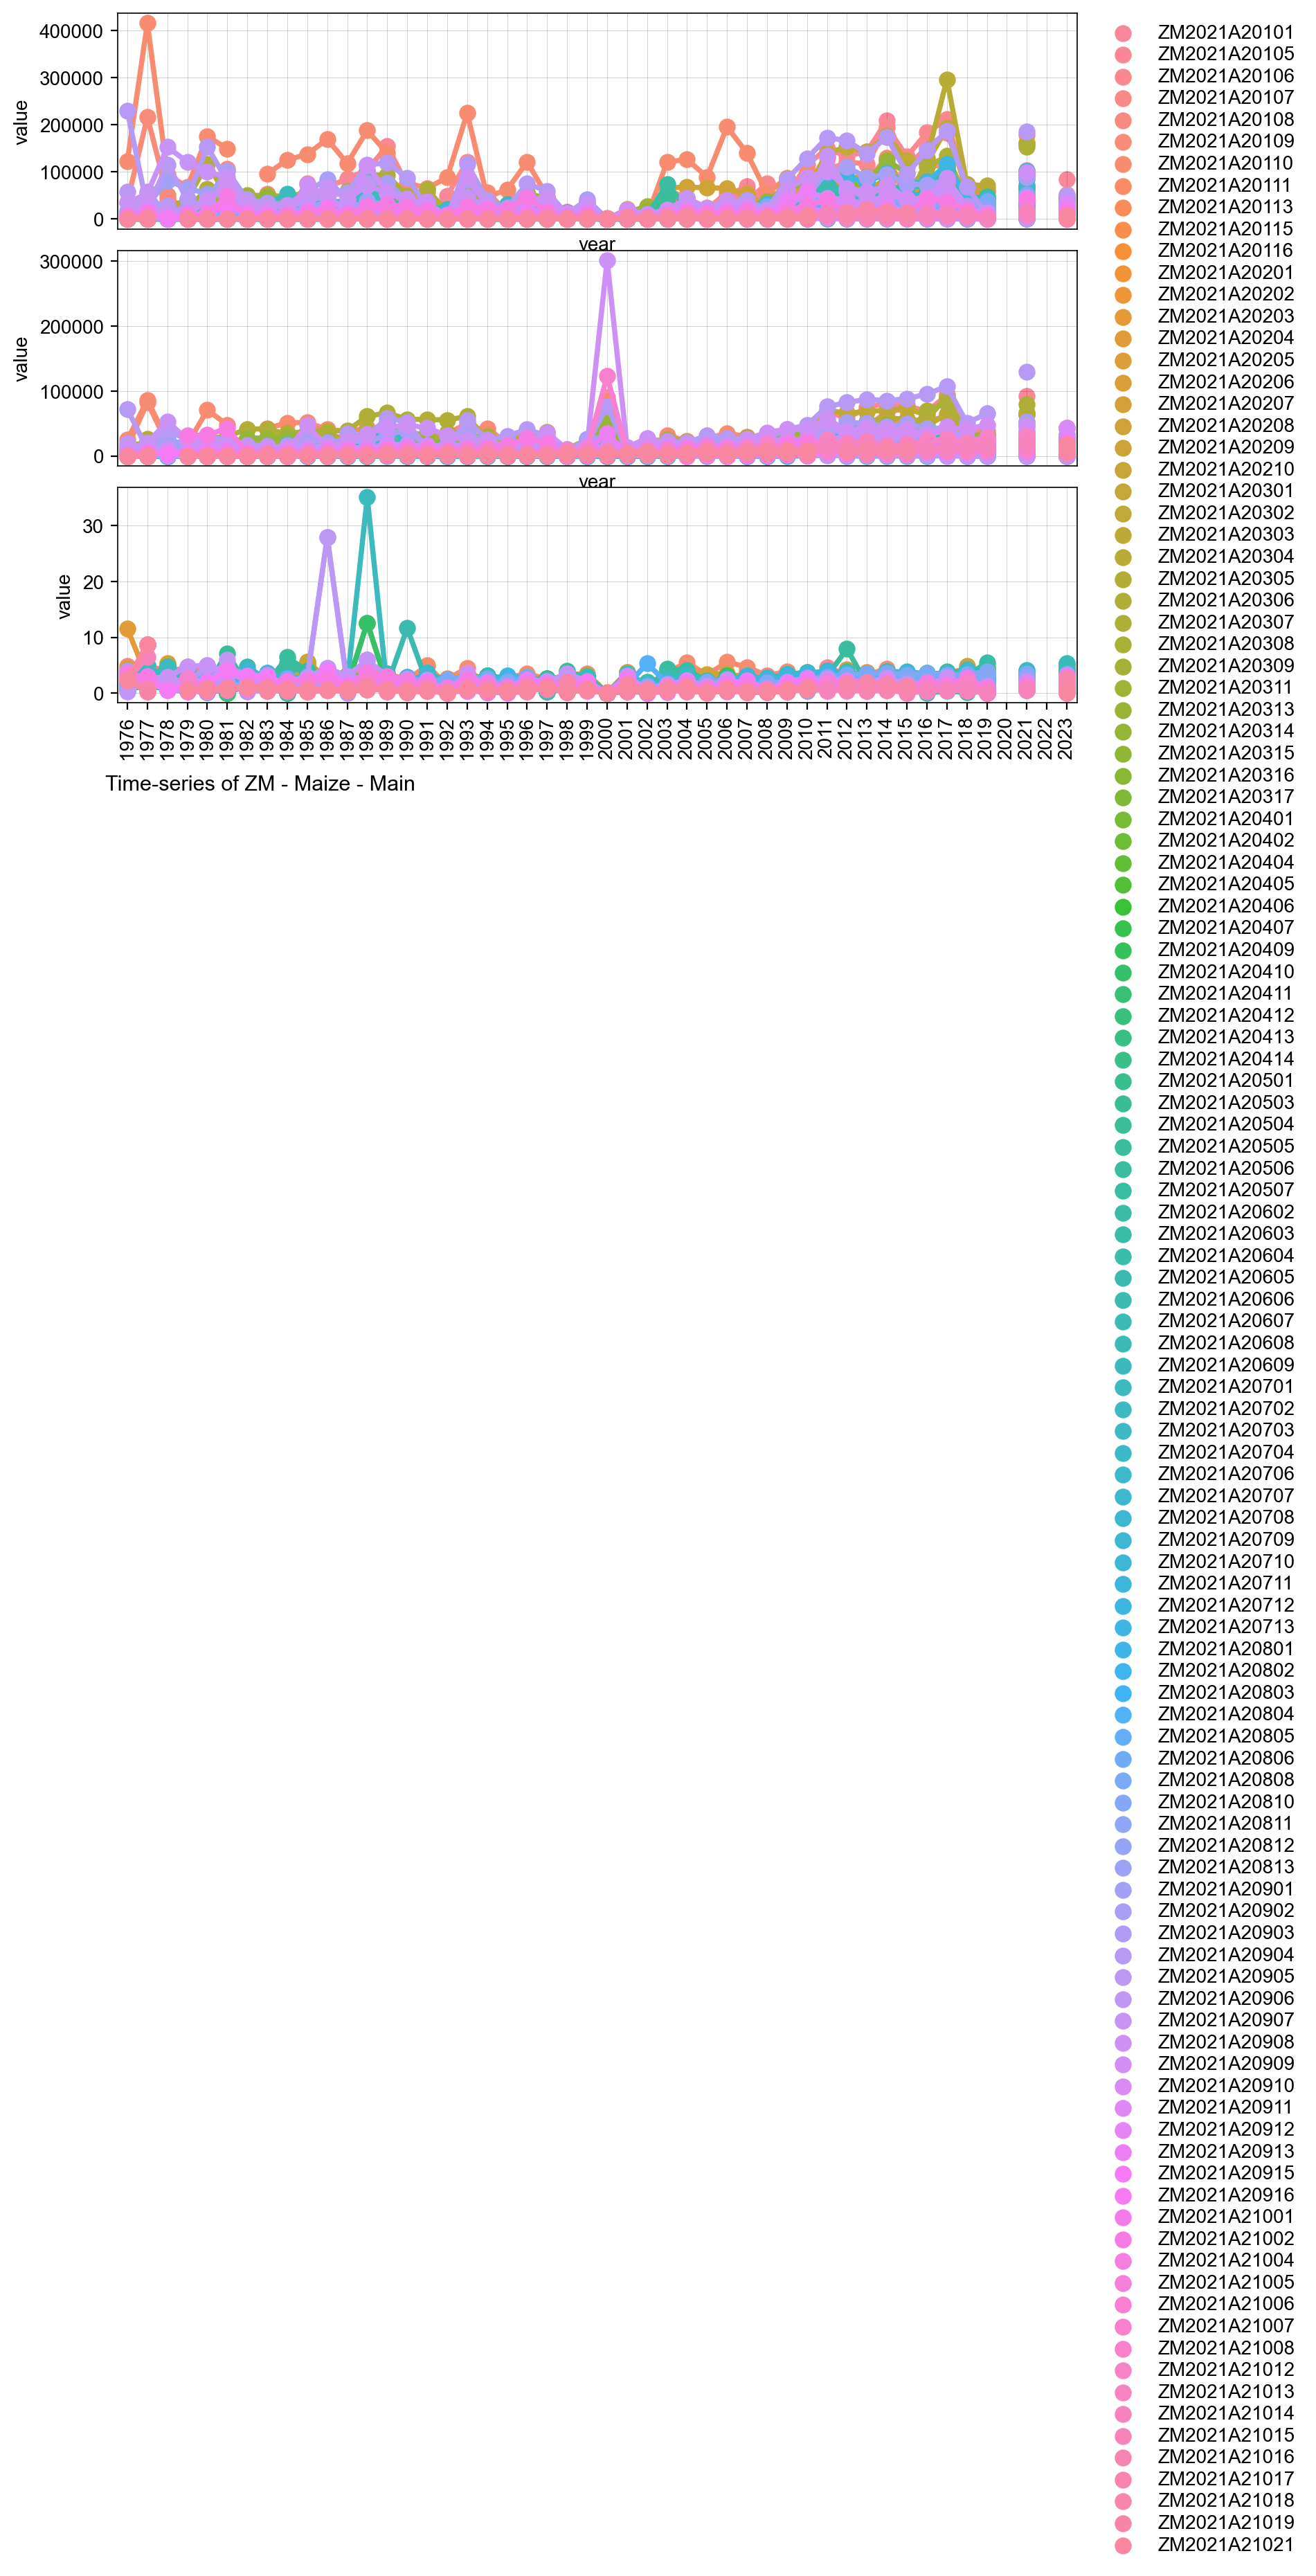

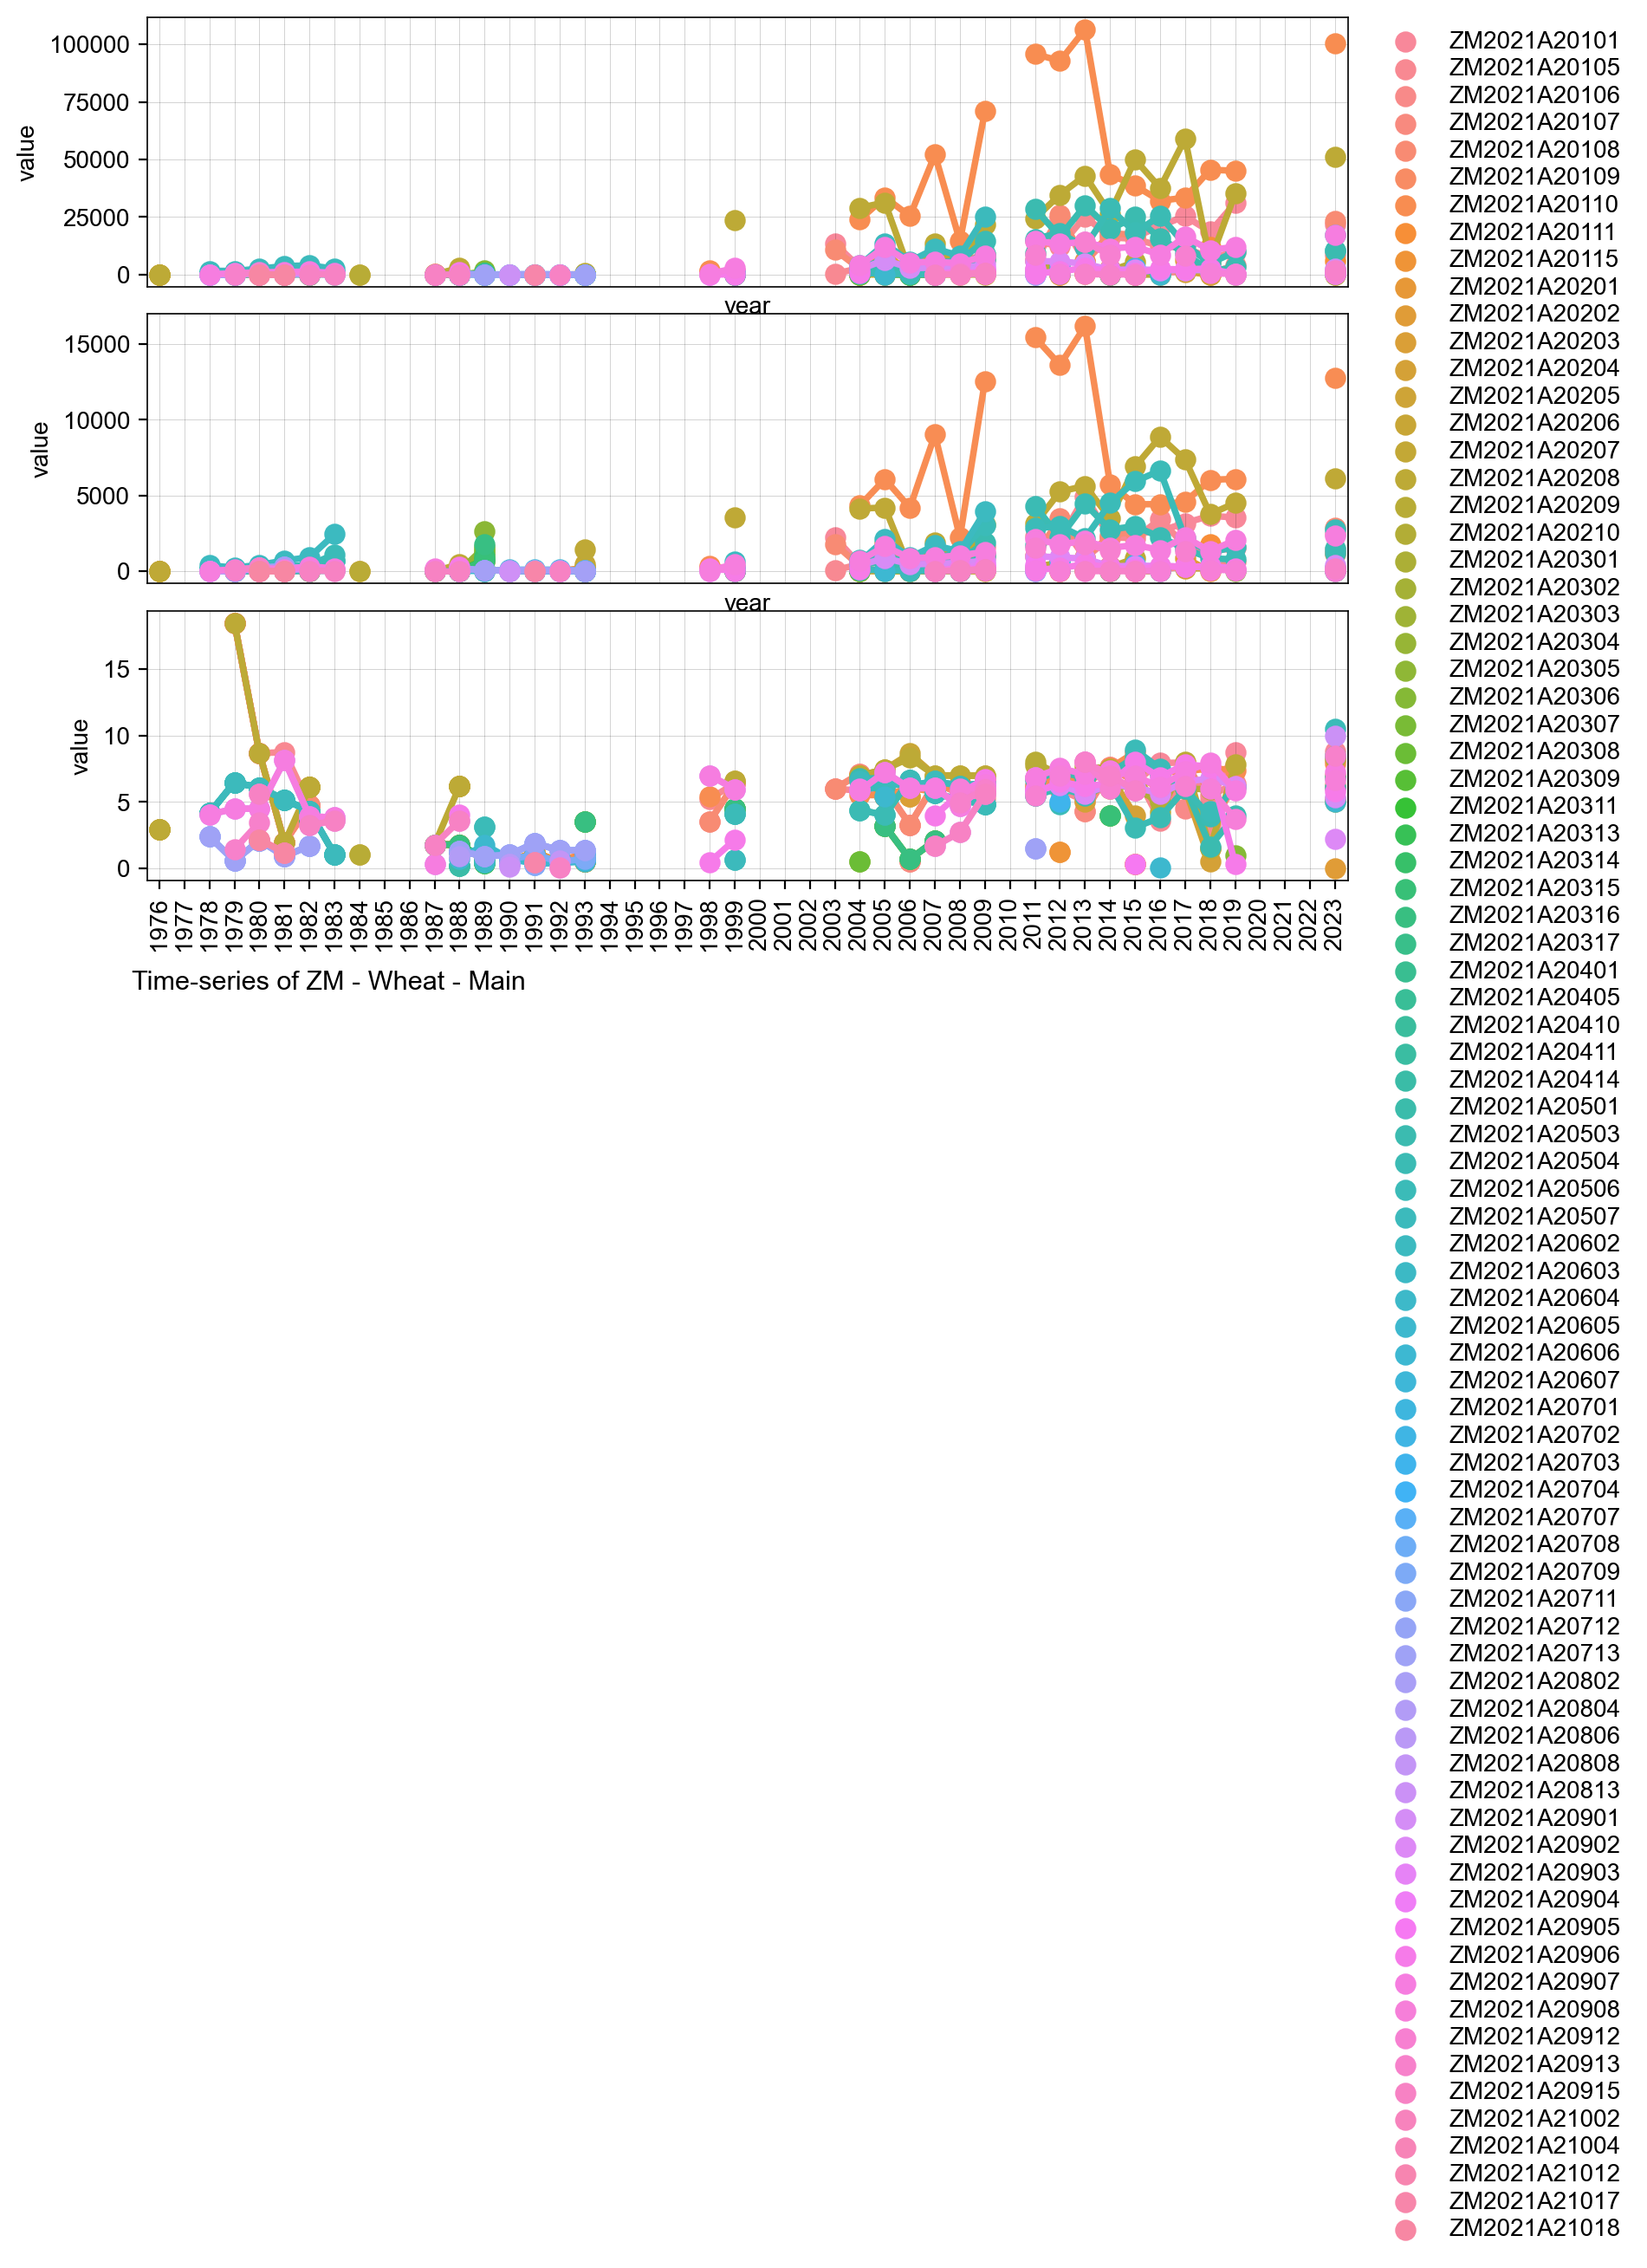

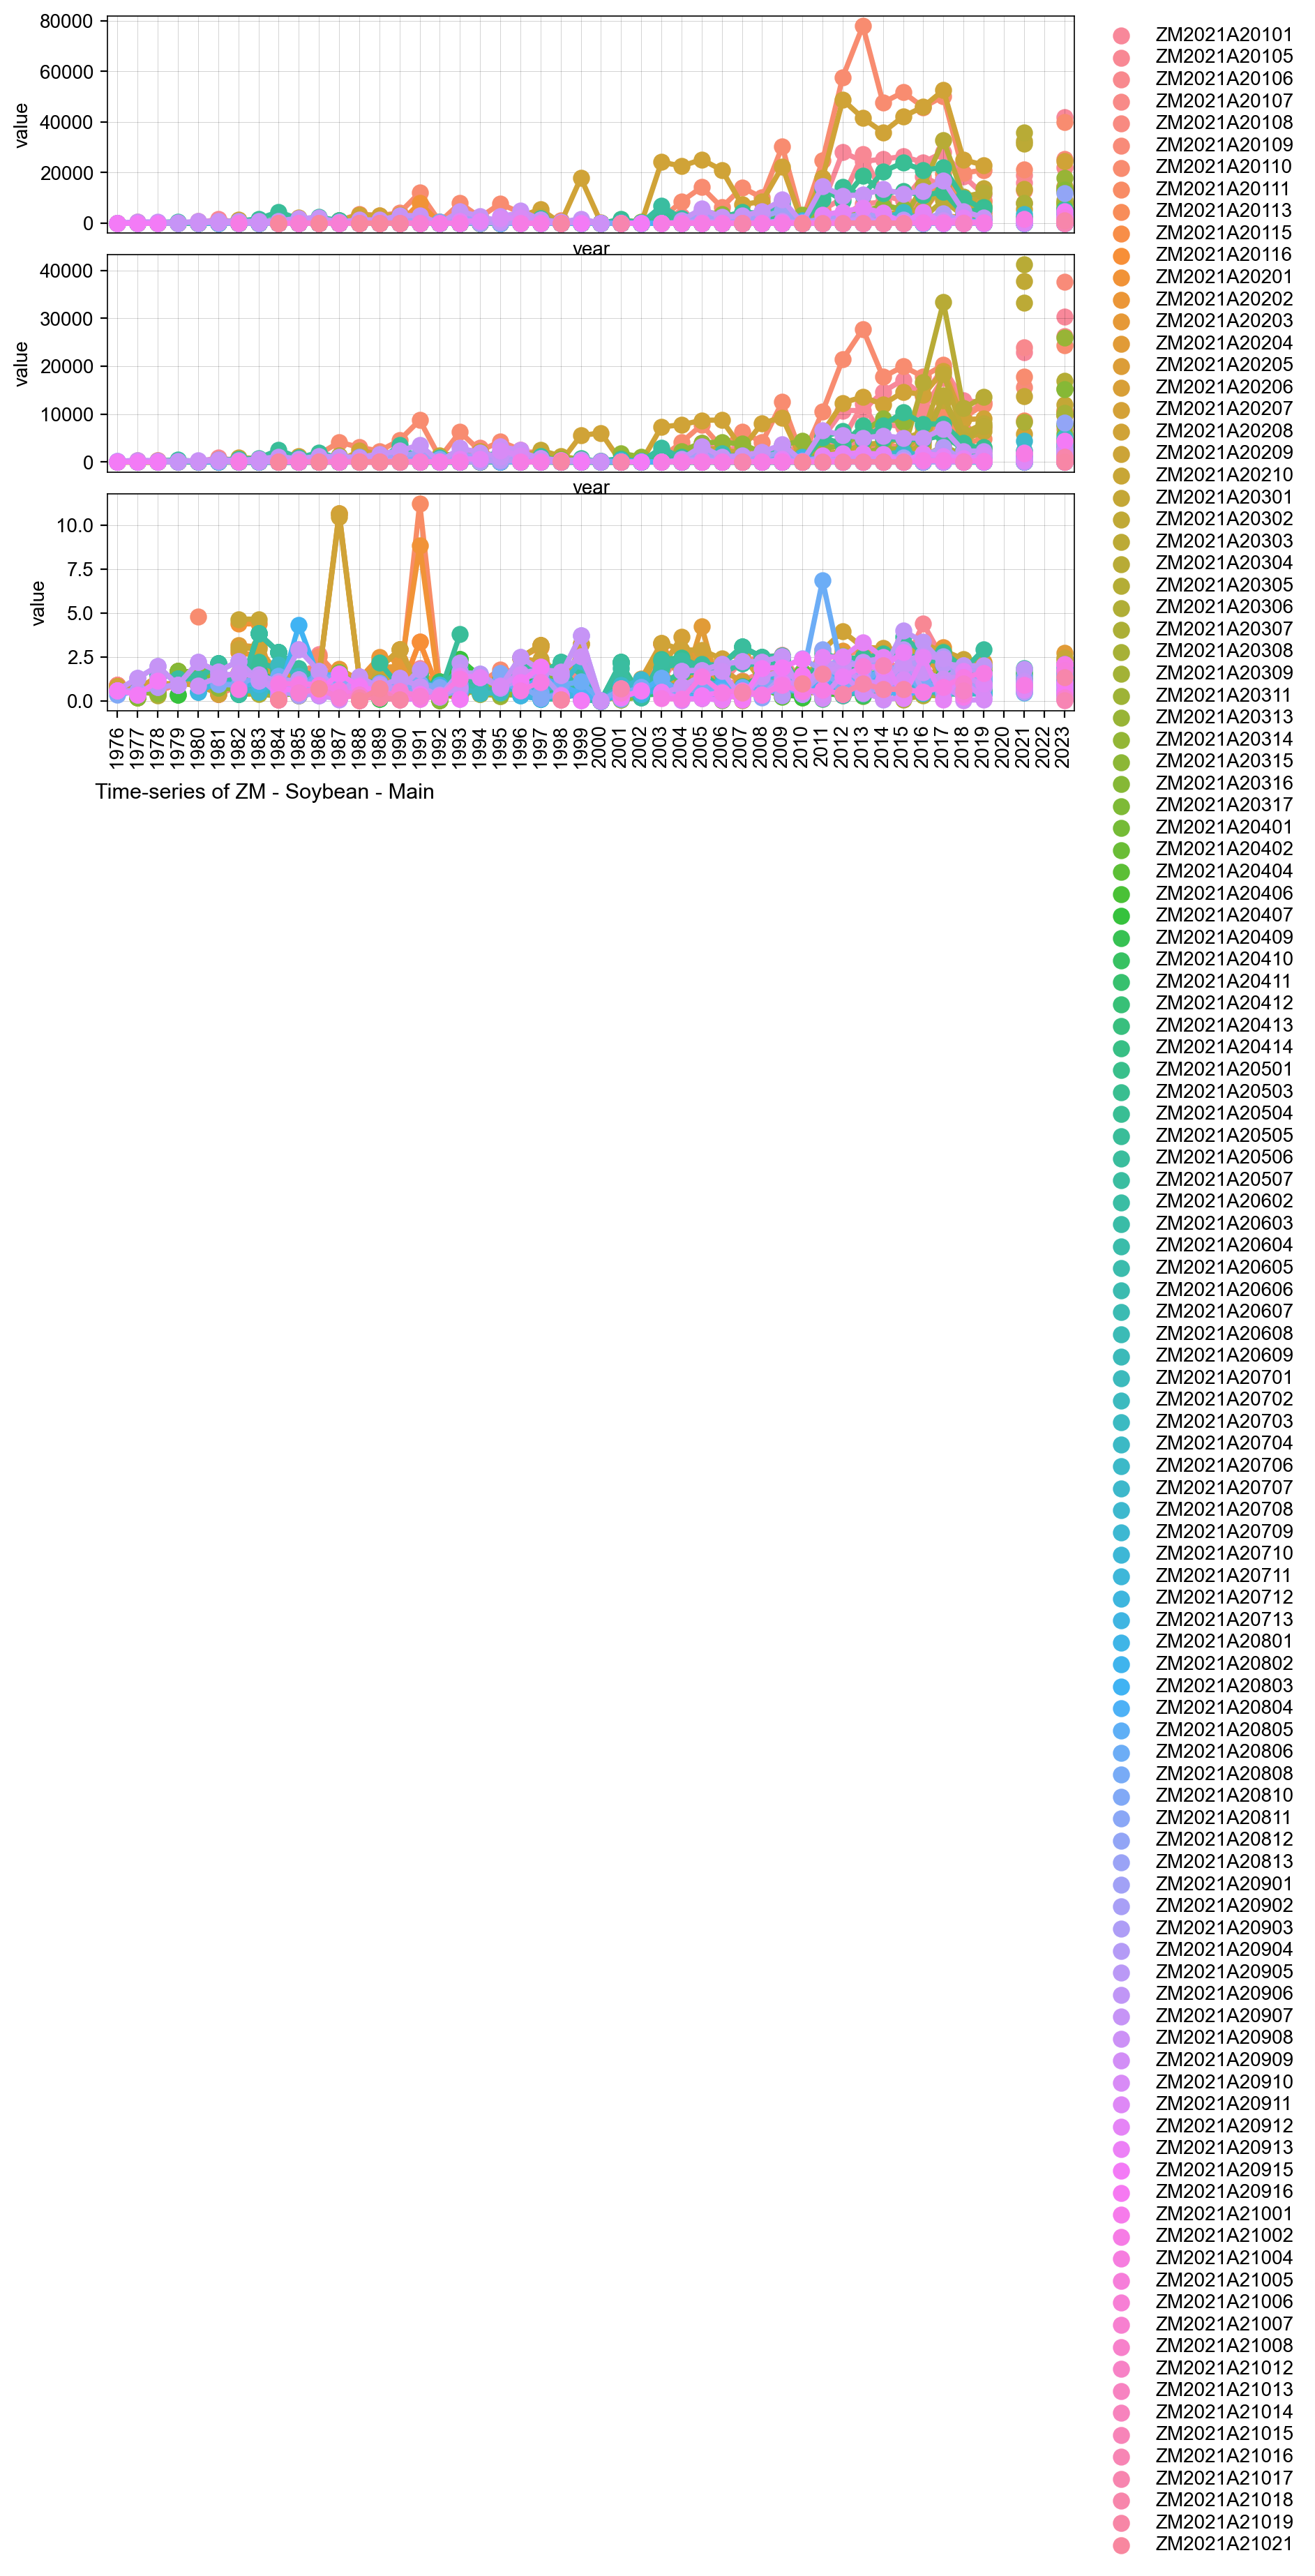

In [9]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'ZM', 'Zambia'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
# df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize','Main'],
    ['Wheat','Main'],
    ['Soybean','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)